notice(2): Group "all" created containing 512 particles


*Warning*: Type 'A' already defined.
*Warning*: Ignoring command to enable a force that is already enabled*Warning*: Box size is too sm

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 512
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:04 | Step 10000 / 10000 | TPS 2156.95 | ETA 00:00:00
Average TPS: 2156.42
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0
notice(2): Average rotate acceptance:    0
notice(2): Trial moves per second:        4.41453e+06
notice(2): Overlap checks per second:     4.41453e+06
notice(2): Overlap checks per trial move: 1
notice(2): Number of overlap errors:      0
-- Neighborlist stats:
0 normal updates / 0 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 0 / n_neigh_avg: 0
shortest rebuild period: 100
-- Cell list stats:
Dimension: 0, 0, 0
** run complete **


all or move size is too large for the minimum image convention.
Testing 819 images per trial move, performance may slow.
This message will not be repeated.


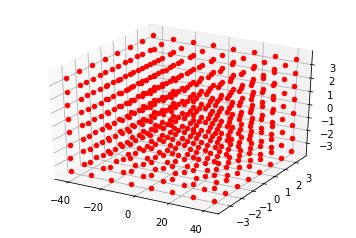

0.0

In [77]:
#Our original contribution will be in the form of a hard particle Monte Carlo
#simulation. The idea here is to use the HOOMD (Monte Carlo package) library
#to generate a rigid lattice with charged particles, and calculate
#the strain on the lattice when an external electric field is applied.
#Using this method we can draw some conclusions about the inverse piezo-
#electric effect where an electric field produced mechanical strain on the
#system.

#Team Catastrophe
#Joshua Milem & Anna Turnbull



from hoomd import *
import hoomd.md as md
import numpy as np
from pylab import *
import hoomd.hpmc as hpmc


context.initialize("CPU")



#Creating our lattice. 16 x 16 2D sheet

#particle_pos = lattice.sq(1.0, ['A'])
#particle_pos = lattice.fcc(5.148, ['R'])


unit_cell = lattice.unitcell(N = 1, 
                                  a1 = [12,0,0],
                                  a2 = [0,1,0],
                                  a3 = [0,0,1],
                                  dimensions = 3,
                                  position = [[0,0,0]],                                  type_name = ['A'],
                                  mass = [147.84558],
                                  moment_inertia = [[0,
                                                    1/12*1.0*8**2,
                                                    1/12*1.0*8**2]],
                                diameter = [0.2],
                                 charge = [5.0],
                                  orientation = [[1,0,0,0]]);


system = init.create_lattice(unitcell=unit_cell, n=[8,8,8])
#system = init.create_lattice(unitcell = lattice.sc(a=5.148), n=[8,8,8])


system.particles.types.add('A')
n1 = md.nlist.cell()
all = group.all()



#Create rigid bodies on either side of the 2D sheet to simulate crystal

#crystallize = md.constrain.rigid()
#crystallize.set_param('R', types=['A']*4,
#                     positions=[(-1,0,0),(-0.5,0,0),(0.5,0,0),(1,0,0)])


#crystallize.create_bodies()


#crystal = group.rigid_center()



lj = md.pair.lj(r_cut=12.0, nlist=n1)
#lj.set_params(mode='shift')
lj.pair_coeff.set(['A'], ['A'], epsilon=1.0, sigma=1.0)

#dipole_pairs = md.pair.dipole(r_cut=2.0, nlist=n1, name=None)


#dipole_force = md.force.dipole(field_x=10.0, field_y=0.0, field_z=0.0,#
#                                             p=1.0)

dipole_force.enable()


e_field = md.external.e_field((10.0,0,0))

mc = hpmc.integrate.simple_polygon(seed=23111)
mc.shape_param.set(['A'], vertices=[(4,-4), (4,4), (-4,4), (-4,-4)])
hpmc.field.lattice_field(mc,k=100.0)




#mc2 = hpmc.integrate.sphere(seed=4999)
#hpmc.field.lattice_field(mc=mc2, position = particle_pos, k=1000.0)



#Langevin dynamics based integration, may switch to Brownian to fix anisotropy error
#efield = md.external.e_field((1.0,0,0))



#md.integrate.mode_standard(dt=0.005)
#md.integrate.langevin(all, kT=1.0, seed=40)




analyze.log(filename="output1.log",
                 quantities=['potential_energy',
                            'translational_kinetic_energy',
                            'rotational_kinetic_energy',
                            'pressure',
                            'lattice_energy'],
                 period=100,
                 overwrite=True);


dump.gsd("trajectory.gsd",
              period=2e1,
              group=group.all(),
              overwrite=True)




run(10000)

lj.get_energy(all)
efield.get_energy(all)


%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

snapshot = system.take_snapshot(all=True)
pos = snapshot.particles.position

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
for part in pos:
    ax.scatter(part[0], part[1], part[2], c='r')
plt.show()


e_field.get_energy(all)

#Currently the issue is coupling the free particle layer to the rigid bodies.
#I do not think this will take much work, I just ran out of time for this 
#piece of the project. 

#HOOMD has an internal energy minimization function which will be used
#to calculate the final energy once the electric strain is applied,
#otherwise strain will be inaccurate.
